## Fase 3. Preparacion de los datos

### 3.1. Lectura de datos

In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import numpy as np
import pyarrow as pq
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
from io import BytesIO
from skimage.color import rgb2gray
from skimage.io import imread
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import optuna
from optuna.visualization import plot_param_importances

import random


c:\Users\spart\miniconda3\envs\alzheimer\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_file = '../train.parquet'
test_file = '../test.parquet'
images_dir = '../images' # También corregimos la ruta base para las imágenes

# Verificamos si las rutas existen
if not os.path.exists(train_file) or not os.path.exists(test_file):
    print(f"Error: No se encontraron los archivos .parquet.")
    print(f"Asegúrate de que la estructura de carpetas y nombres de archivo sea correcta.")
    print(f"Buscando en: {os.path.abspath(train_file)}") # Ayuda a depurar
else:
    print("Archivos .parquet encontrados. Cargando datos...")
    
    # Intentamos cargar los dataframes
    try:
        train_df = pd.read_parquet(train_file)
        test_df = pd.read_parquet(test_file)
        
        # Añadimos la columna 'split' para identificar el origen de los datos
        train_df['split'] = 'train'
        test_df['split'] = 'test'

        # Combinamos ambos dataframes para el análisis exploratorio
        df = pd.concat([train_df, test_df], ignore_index=True)
        
        # Usamos la ruta de imágenes corregida
        
        print(f"Carga completa. Se encontraron {len(df)} registros en total.")
        print(f"({len(train_df)} en entrenamiento y {len(test_df)} en prueba)") 

    except Exception as e:
        print(f"Ocurrió un error al leer los archivos: {e}")
        print("Asegúrate de haber instalado 'pyarrow' y reiniciado el kernel.")

Archivos .parquet encontrados. Cargando datos...
Carga completa. Se encontraron 6400 registros en total.
(5120 en entrenamiento y 1280 en prueba)


### 3.2. Carga de imagenes y Visualizacion de una imagen de prueba

dict_keys(['bytes', 'path'])
Total de imágenes cargadas y listas para usar: 6400


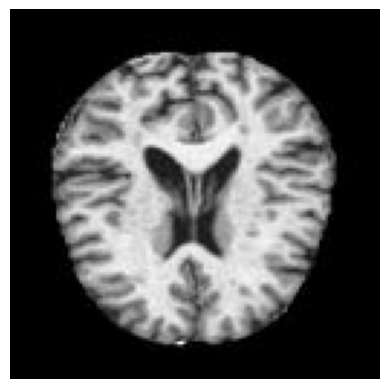

In [3]:
# Carga de primera imagen para verificación
images_df = df['image']
charged_images = []
counter = 0

print(images_df[0].keys())

## Prueba de la primera imagen
# image_bytes = images_df[0].pop('bytes')
# Esto es necesario para que la función Image.open() de PIL pueda leer los datos.
# image_stream = BytesIO(image_bytes)
# skimage abre e interpreta los bytes del formato JPEG en una matriz NumPy.
# image_array = imread(image_stream)
# charged_images.append(image_array)

for dictionary in images_df:
    try:
        image_bytes = dictionary.pop('bytes')
        # Esto es necesario para que la función Image.open() de PIL pueda leer los datos.
        image_stream = BytesIO(image_bytes)
        # skimage abre e interpreta los bytes del formato JPEG en una matriz NumPy.
        image_array = imread(image_stream)
        charged_images.append(image_array)
        counter += 1
    except Exception as e:
        print(f"Error al cargar la imagen: {counter}, error: {e}")

print(f"Total de imágenes cargadas y listas para usar: {len(charged_images)}")
# Visualización de una imagen de prueba
plt.imshow(charged_images[0], cmap='gray')
plt.axis('off')
plt.show()

### 3.3. Transformacion a escala de grises

Debido al analisis realizado en la Fase 1 y Fase 2, se llego a que todas las imagenes ya estan en escala de grises y no hay datos faltantes, por lo que me saltare este paso y el paso de quitar imagenes faltantes.

In [4]:
# Verificación de las dimensiones de la imagen
for image in charged_images:
    if image.shape != (128, 128):
        print(f"Advertencia: Se encontró una imagen con dimensiones inesperadas: {image.shape}")


### 3.4. Aplicar PCA a cada una de las imagenes para obtener vector de caracteristicas



La función utiliza PCA con n_components=1 para:

*   Encontrar la dirección de máxima varianza (el Primer Componente Principal o PC1) de la imagen de entrada (img).

*   Devuelve este PC1 como un vector unidimensional (la línea pca.components_.flatten()).

Propósito Final: Crear una nueva colección (normalized_greyscale) donde cada imagen original ha sido reemplazada por su vector de características PC1, logrando una representación de datos altamente reducida y normalizada.

In [5]:
def normalization(img):
  pca = PCA(n_components=1)
  pca.fit(img)
  return pca.components_.flatten()

normalized_greyscale = []

for img in charged_images:
  normalized_greyscale.append(normalization(img))

### 3.5. Construcción del nuevo dataset PCA con clase

Recordemos que para la clase o label tenemos que:
*   0=Mild_Demented
*   1=Moderate_Demented
*   2=Non_Demented
*   3=Very_Mild_Demented

In [6]:
# Construir el DataFrame
new_df = pd.DataFrame(normalized_greyscale)
new_df["clase"] = df["label"]  # Agregar la columna de clase

# Mostrar las primeras filas del dataset
print(new_df.head())

              0             1             2             3             4  \
0 -1.407338e-17  8.881784e-16  2.775558e-17 -0.000000e+00 -0.000000e+00   
1 -1.558456e-17 -1.110223e-16 -0.000000e+00 -0.000000e+00 -1.084202e-19   
2 -1.408422e-17  3.330669e-16 -0.000000e+00 -1.734723e-18  5.421011e-20   
3 -1.283411e-17 -3.330669e-16 -0.000000e+00 -0.000000e+00 -0.000000e+00   
4 -1.504597e-17 -1.110223e-16 -0.000000e+00 -0.000000e+00 -0.000000e+00   

              5             6             7         8         9  ...  \
0  1.694066e-21 -0.000000e+00 -0.000000e+00  0.000206  0.000220  ...   
1 -0.000000e+00 -0.000000e+00 -8.271806e-25  0.000289  0.000204  ...   
2 -0.000000e+00  5.293956e-23 -0.000000e+00  0.000337  0.000242  ...   
3 -0.000000e+00  2.646978e-23 -8.271806e-25  0.000203  0.000284  ...   
4 -0.000000e+00 -0.000000e+00  1.654361e-24  0.000175  0.000285  ...   

        119  120  121  122  123  124  125  126  127  clase  
0  0.000096 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0    

### 3.6. Separacion de datos

In [7]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)


In [8]:
y = new_df['clase']
X = new_df.drop(columns=['clase'])

# Dividir en entrenamiento (70%) y prueba (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED, stratify=y)

### 3.8. Balanceo de los datos

Debido a la distribucion desbalanceada de las clases observada en la Fase 1 y Fase 2, se ha decidido seguir estrategias de undersampling en un 20% de los datos en la clase mayoritaria y para las dos cllases minoritarias se eligio que tuviesen el mismo numero de registros que la segunda clase mayoritaria para que quedasen casi iguales.

In [9]:
print("Distribución de clases original en el conjunto de entrenamiento:")
print(sorted(Counter(y_train).items()))

# --- 3. Undersampling de la clase mayoritaria (clase "2") ---
# Se calcula el número de muestras para la clase 2 tras una reducción del 20%.
n_class_2 = int(Counter(y_train)[2] * 0.8)

# Se define la estrategia de undersampling.
# Solo se aplicará a la clase 2.
undersampling_strategy = {2: n_class_2}

# Se aplica el undersampling.
rus = RandomUnderSampler(sampling_strategy=undersampling_strategy, random_state=42)
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

print("\nDistribución de clases después del undersampling:")
print(sorted(Counter(y_train_under).items()))

# --- 4. Oversampling con SMOTE para las clases "0" y "1" ---
# Se obtiene el número de registros de la clase "3" como objetivo.
n_class_3 = Counter(y_train_under)[3]

# Se define la estrategia de oversampling para las clases 0 y 1.
# Se asegura que las clases que no se quieren sobremuestrear mantengan sus efectivos.
oversampling_strategy = {
    0: n_class_3,
    1: n_class_3,
    2: Counter(y_train_under)[2], # Mantiene las muestras de la clase 2
    3: n_class_3  # Mantiene las muestras de la clase 3
}

# Se aplica SMOTE.
smote = SMOTE(sampling_strategy=oversampling_strategy, random_state=42, k_neighbors=5)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_under, y_train_under)

print("\nDistribución de clases final después de SMOTE:")
print(sorted(Counter(y_train_resampled).items()))

print("\nForma de los datos de entrenamiento finales:", X_train_resampled.shape)

Distribución de clases original en el conjunto de entrenamiento:
[(0, 627), (1, 45), (2, 2240), (3, 1568)]

Distribución de clases después del undersampling:
[(0, 627), (1, 45), (2, 1792), (3, 1568)]

Distribución de clases final después de SMOTE:
[(0, 1568), (1, 1568), (2, 1792), (3, 1568)]

Forma de los datos de entrenamiento finales: (6496, 128)


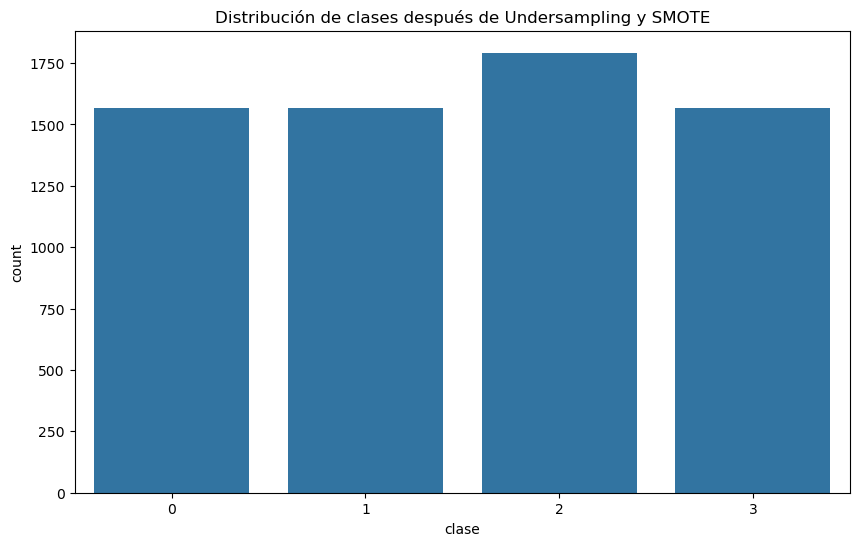

In [10]:

plt.figure(figsize=(10, 6))
sns.countplot(x=y_train_resampled)
plt.title('Distribución de clases después de Undersampling y SMOTE')
plt.show()

### 3.9. Codificación de las variables de salida

In [11]:
# Creacion del codificador OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Codificación de las variables de salida
y_train_encoded = encoder.fit_transform(pd.DataFrame(y_train_resampled))
y_test_encoded = encoder.transform(pd.DataFrame(y_test))

# Conversion a DataFrame
columns_names = ['class_0(Mild_Demented)', 'class_1(Moderate_Demented)', 'class_2(Non_Demented)', 'class_3(Very_Mild_Demented)']
y_train_encoded = pd.DataFrame(y_train_encoded, columns=columns_names)
y_test_encoded = pd.DataFrame(y_test_encoded, columns=columns_names)

#### 3.10. Normalizacion

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler_mm_res = MinMaxScaler()
scaler_mm_res.fit(X_train_resampled)

X_train_normalized = scaler_mm_res.transform(X_train_resampled)

X_test_normalized = scaler_mm_res.transform(X_test)

Ahora se deberia de usar y_train_encoded y y_test_encoded para entrenar el modelo

## Fase 4. Construcción del modelo

Primero se define un modelo base que tomara optuna para irlo mejorando

### 4.1. Busqueda de mejores hiperparametros con optuna

En lugar de elegir manualmente los hiperparámetros (número de neuronas, tasa de aprendizaje, etc.), utilizaremos Optuna para encontrar la mejor combinación de manera automática y eficiente.
Métrica a Optimizar: Debido al desbalance de clases, optimizaremos para obtener el máximo F1-Score en el conjunto de prueba, ya que esta métrica representa un balance armónico entre la precisión y el recall.

In [13]:
print("Iniciando proceso de optimización con Optuna...")

def objective(trial):
    # Definición de hiperparámetros a optimizar
    hidden_layer_sizes = trial.suggest_categorical('hidden_layer_sizes', [ (128, 32, 16), (256, 64, 32),(512, 256, 128)])
    alpha = trial.suggest_loguniform('alpha', 1e-7, 1e-3)
    learning_rate_init = trial.suggest_loguniform('learning_rate_init', 1e-4, 1e-1)
    momentum = trial.suggest_uniform('momentum', 0.5, 0.99)
    
    # Creación del modelo con los hiperparámetros sugeridos
    model = MLPClassifier(
        solver='adam', activation='relu', alpha=alpha, tol=1e-4,
        hidden_layer_sizes=hidden_layer_sizes, learning_rate='adaptive',
        learning_rate_init=learning_rate_init,
        max_iter=1000, momentum=momentum, verbose=False
    )
    
    # Entrenamiento del modelo
    model.fit(X_train_resampled, y_train_encoded)
    
    # Predicciones en el conjunto de prueba
    y_pred = model.predict(X_test)
    
    # Cálculo del F1-score macro
    f1 = f1_score(y_test_encoded, y_pred, average='macro')
    
    return f1
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10, timeout=1200)

print("\n--- Optimización Completada ---")
print(f"Mejor F1-Score (Clase 0) encontrado: {study.best_value:.4f}")
print("Mejores Hiperparámetros encontrados:", study.best_params)



[I 2025-10-01 09:43:07,310] A new study created in memory with name: no-name-2c986eff-c890-4dfe-ac37-88ceda9390d9


Iniciando proceso de optimización con Optuna...


c:\Users\spart\miniconda3\envs\alzheimer\Lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (128, 32, 16) which is of type tuple.
  warnings.warn(message)
c:\Users\spart\miniconda3\envs\alzheimer\Lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (256, 64, 32) which is of type tuple.
  warnings.warn(message)
c:\Users\spart\miniconda3\envs\alzheimer\Lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (512, 256, 128) which is of type tuple.
  warnings.warn(message)
C:\Users\spart\AppData\Local\Temp\ipykernel_2456\1241840325.py:6: FutureWarning: suggest_loguniform has been deprecated in v3


--- Optimización Completada ---
Mejor F1-Score (Clase 0) encontrado: 0.6546
Mejores Hiperparámetros encontrados: {'hidden_layer_sizes': (512, 256, 128), 'alpha': 0.0001735490001774621, 'learning_rate_init': 0.0008530914407093651, 'momentum': 0.790354423653301}


### 4.2 Construcción de modelos

Debido a que al realizar el ejercicio, la precision no mejorá mucho, es pertinente hacer otro modelo que tenga mejor curva de aprendizaje para compararlos.

#### 4.2.1 Construcción del modelo base

In [14]:
mlp = MLPClassifier(
    solver='adam', activation='relu', alpha=1e-6, tol=1e-4,
    hidden_layer_sizes=(64, 16, 10), learning_rate='adaptive',
    learning_rate_init=0.001,
    max_iter=500, momentum=0.9, verbose=True
)

#### 4.2.2. Construcción del modelo optimizado para mejor f1-score en la clase mayoritaria

In [15]:
print("\n--- Entrenando Modelos Finales con los Mejores Hiperparámetros ---")

# Hacemos una copia del diccionario de mejores parámetros para poder modificarlo de forma segura.
best_params_config = study.best_params.copy()

# Modelo
final_model = MLPClassifier(
    solver='adam',
    activation='relu',
    alpha=best_params_config['alpha'],
    tol=1e-4,
    hidden_layer_sizes=best_params_config['hidden_layer_sizes'],
    learning_rate='adaptive',
    learning_rate_init=best_params_config['learning_rate_init'],
    max_iter=500,
    momentum=best_params_config['momentum'],
    verbose=True
)


--- Entrenando Modelos Finales con los Mejores Hiperparámetros ---


### 4.3. Entrenamiento de los modelos

Iteration 1, loss = 2.85448327
Iteration 2, loss = 2.65925241
Iteration 3, loss = 2.49718430
Iteration 4, loss = 2.37195219
Iteration 5, loss = 2.27244918
Iteration 6, loss = 2.18294288
Iteration 7, loss = 2.10506452
Iteration 8, loss = 2.03584219
Iteration 9, loss = 1.97782382
Iteration 10, loss = 1.91767143
Iteration 11, loss = 1.86104984
Iteration 12, loss = 1.80586955
Iteration 13, loss = 1.75373666
Iteration 14, loss = 1.70928588
Iteration 15, loss = 1.68198126
Iteration 16, loss = 1.65184229
Iteration 17, loss = 1.61824970
Iteration 18, loss = 1.59484011
Iteration 19, loss = 1.57334880
Iteration 20, loss = 1.55148756
Iteration 21, loss = 1.53885866
Iteration 22, loss = 1.51966327
Iteration 23, loss = 1.50126375
Iteration 24, loss = 1.48923994
Iteration 25, loss = 1.47569792
Iteration 26, loss = 1.47594942
Iteration 27, loss = 1.44964895
Iteration 28, loss = 1.44624002
Iteration 29, loss = 1.44935236
Iteration 30, loss = 1.42416054
Iteration 31, loss = 1.41907158
Iteration 32, los

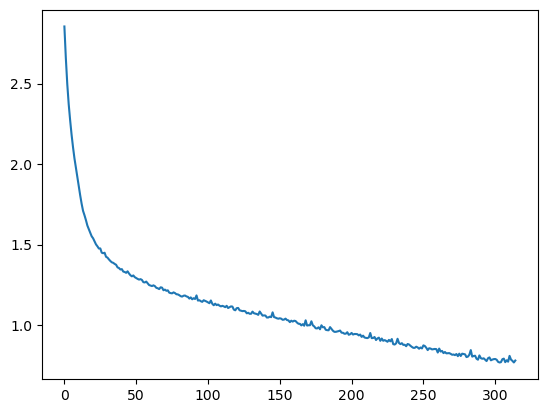

In [16]:
mlp.fit(X_train_normalized, y_train_encoded)
# Imprimir la pérdida en cada iteración
for i, loss in enumerate(mlp.loss_curve_):
    print(f"Iteración {i+1}: Pérdida = {loss}")
plt.plot(mlp.loss_curve_)

Iteration 1, loss = 2.27175383
Iteration 2, loss = 2.07345364
Iteration 3, loss = 1.84178799
Iteration 4, loss = 1.70162036
Iteration 5, loss = 1.60116527
Iteration 6, loss = 1.54231526
Iteration 7, loss = 1.48174478
Iteration 8, loss = 1.43874350
Iteration 9, loss = 1.41523644
Iteration 10, loss = 1.36327959
Iteration 11, loss = 1.33983237
Iteration 12, loss = 1.32936737
Iteration 13, loss = 1.29964637
Iteration 14, loss = 1.28894456
Iteration 15, loss = 1.26939688
Iteration 16, loss = 1.25308982
Iteration 17, loss = 1.24481220
Iteration 18, loss = 1.22742999
Iteration 19, loss = 1.20453231
Iteration 20, loss = 1.18611011
Iteration 21, loss = 1.19733188
Iteration 22, loss = 1.18012545
Iteration 23, loss = 1.15508691
Iteration 24, loss = 1.15292194
Iteration 25, loss = 1.13445301
Iteration 26, loss = 1.12054971
Iteration 27, loss = 1.09872714
Iteration 28, loss = 1.10249474
Iteration 29, loss = 1.06973468
Iteration 30, loss = 1.03916867
Iteration 31, loss = 1.00897503
Iteration 32, los

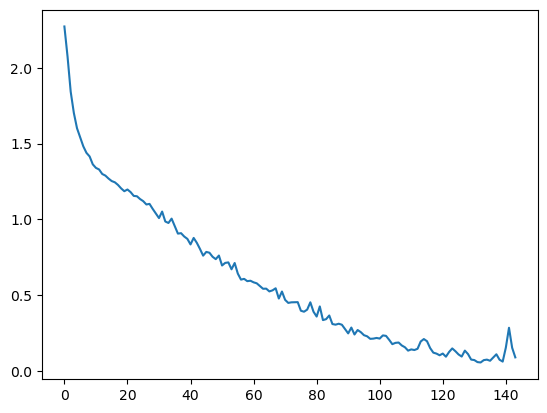

In [17]:
# Entrenamiento del modelo final
final_model.fit(X_train_normalized, y_train_encoded)
plt.plot(final_model.loss_curve_)

## Fase 5: Evaluación


EVALUACIÓN DEL MODELO 1: SIN OPTUNA

========== Reporte de Evaluación para: MLP con Datos sin optuna ==========

--- Accuracy ---
Accuracy: 0.5974

--- Reporte de Clasificación (Conjunto de Prueba) ---
                             precision    recall  f1-score   support

     class_0(Mild_Demented)       0.55      0.48      0.51       269
 class_1(Moderate_Demented)       0.62      0.79      0.70        19
      class_2(Non_Demented)       0.76      0.72      0.74       960
class_3(Very_Mild_Demented)       0.61      0.52      0.56       672

                  micro avg       0.68      0.62      0.65      1920
                  macro avg       0.64      0.63      0.63      1920
               weighted avg       0.68      0.62      0.65      1920
                samples avg       0.61      0.62      0.61      1920


--- Matriz de Confusión ---
[!] ANÁLISIS DE ERRORES: Total de clasificaciones incorrectas: 696

Confusiones más significativas:
  - 3 casos de Mild_Demented clasificados co

c:\Users\spart\miniconda3\envs\alzheimer\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


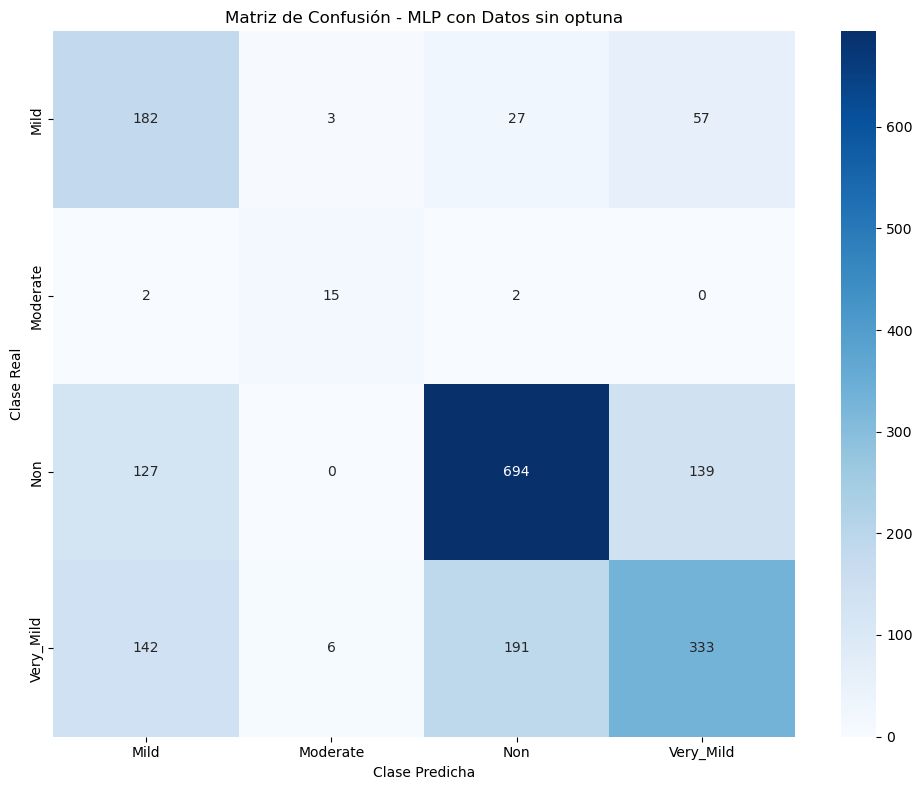


--- Curvas de Aprendizaje para: MLP con Datos sin optuna ---


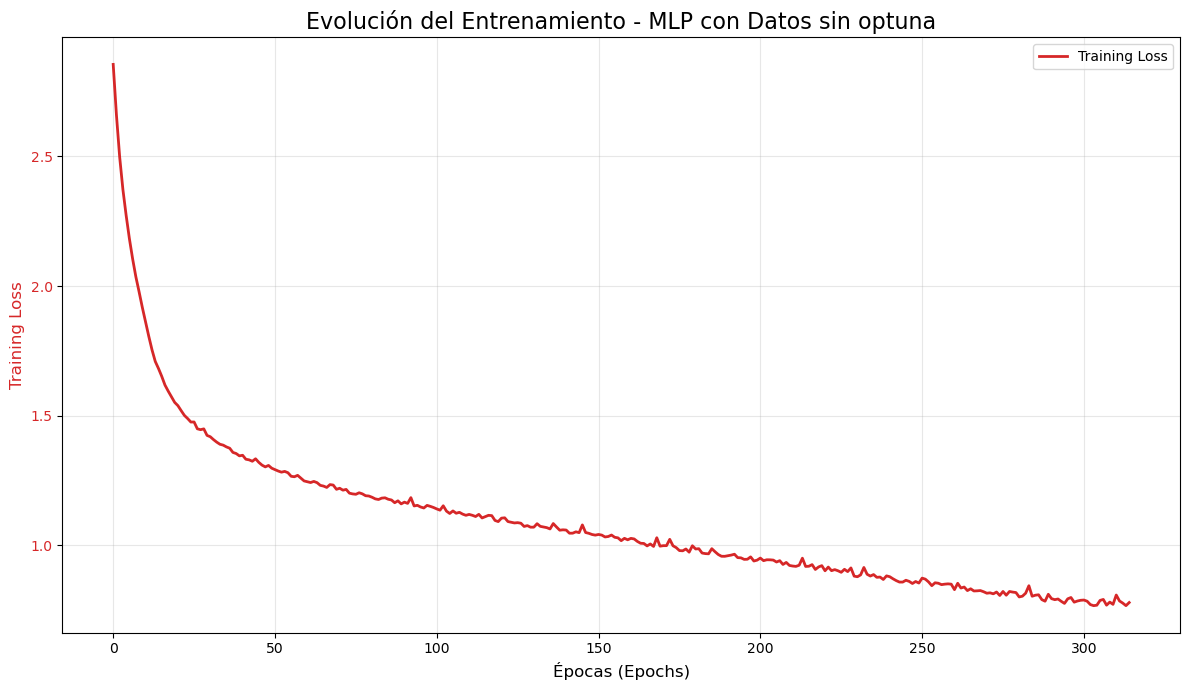


EVALUACIÓN DEL MODELO 2: CON OPTUNA

========== Reporte de Evaluación para: MLP con optuna ==========

--- Accuracy ---
Accuracy: 0.8052

--- Reporte de Clasificación (Conjunto de Prueba) ---
                             precision    recall  f1-score   support

     class_0(Mild_Demented)       0.74      0.77      0.75       269
 class_1(Moderate_Demented)       1.00      0.95      0.97        19
      class_2(Non_Demented)       0.85      0.91      0.88       960
class_3(Very_Mild_Demented)       0.85      0.72      0.78       672

                  micro avg       0.84      0.82      0.83      1920
                  macro avg       0.86      0.84      0.85      1920
               weighted avg       0.84      0.82      0.83      1920
                samples avg       0.81      0.82      0.82      1920


--- Matriz de Confusión ---
[!] ANÁLISIS DE ERRORES: Total de clasificaciones incorrectas: 346

Confusiones más significativas:
  - 22 casos de Mild_Demented clasificados como Non_De

c:\Users\spart\miniconda3\envs\alzheimer\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


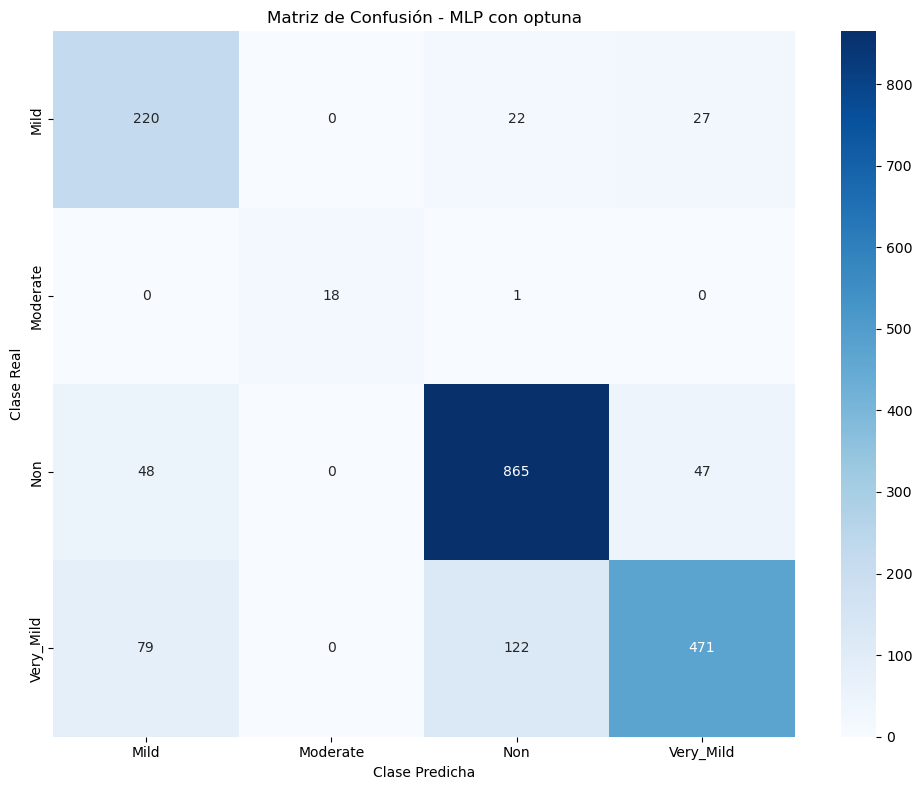


--- Curvas de Aprendizaje para: MLP con optuna ---


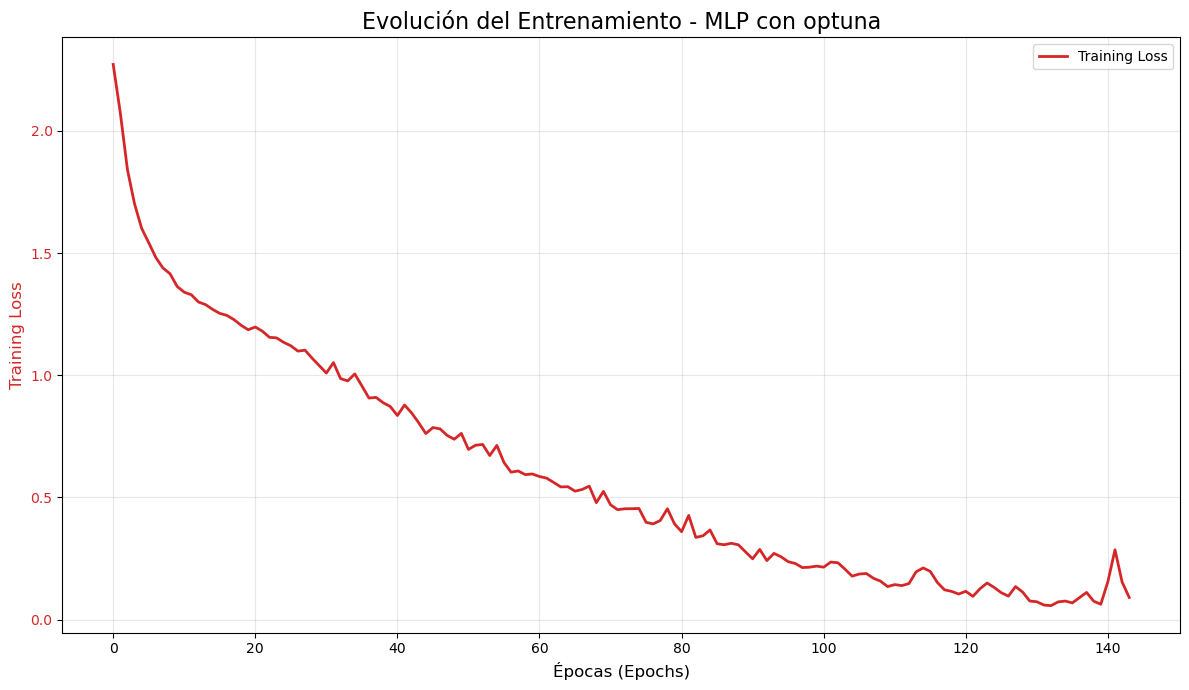

In [18]:
def generate_evaluation_report(model, X_test, y_test, model_name="Modelo"):
    print(f"\n========== Reporte de Evaluación para: {model_name} ==========")
    
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)

    print(f"\n--- Accuracy ---")
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    print("\n--- Reporte de Clasificación (Conjunto de Prueba) ---")
    print(classification_report(y_test, y_pred, target_names=columns_names))

    print("\n--- Matriz de Confusión ---")
    cm = confusion_matrix(y_test.values.argmax(axis=1), y_pred.argmax(axis=1))

    # Análisis de errores críticos para multiclase
    total_errors = np.sum(cm) - np.trace(cm)
    print(f"[!] ANÁLISIS DE ERRORES: Total de clasificaciones incorrectas: {total_errors:,}")
    
    # Identificar las confusiones más críticas
    print("\nConfusiones más significativas:")
    for i in range(len(cm)):
        for j in range(len(cm)):
            if i != j and cm[i, j] > 0:
                class_names = ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']
                print(f"  - {cm[i, j]:,} casos de {class_names[i]} clasificados como {class_names[j]}")
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Mild', 'Moderate', 'Non', 'Very_Mild'],
                yticklabels=['Mild', 'Moderate', 'Non', 'Very_Mild'])
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.ylabel('Clase Real')
    plt.xlabel('Clase Predicha')
    plt.tight_layout()
    plt.show()



def plot_learning_curves(model, model_name):
    print(f"\n--- Curvas de Aprendizaje para: {model_name} ---")
    fig, ax1 = plt.subplots(figsize=(12, 7))
    color = 'tab:red'
    ax1.set_xlabel('Épocas (Epochs)', fontsize=12)
    ax1.set_ylabel('Training Loss', color=color, fontsize=12)
    ax1.plot(model.loss_curve_, color=color, label='Training Loss', linewidth=2)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    plt.title(f'Evolución del Entrenamiento - {model_name}', fontsize=16)
    plt.tight_layout()
    plt.show()


# Ejecutar evaluaciones
print("\n" + "="*50 + "\nEVALUACIÓN DEL MODELO 1: SIN OPTUNA\n" + "="*50)
generate_evaluation_report(mlp, X_test_normalized, y_test_encoded, "MLP con Datos sin optuna")
plot_learning_curves(mlp, "MLP con Datos sin optuna")

print("\n" + "="*50 + "\nEVALUACIÓN DEL MODELO 2: CON OPTUNA\n" + "="*50)
generate_evaluation_report(final_model, X_test_normalized, y_test_encoded, "MLP con optuna")
plot_learning_curves(final_model, "MLP con optuna")